Input feature selection
=====

In this notebook we will compare different selections of input features, i.e. coordinates or order parameters used for an MSM analysis. We will study ways of making reasonable feature selections and distinguishing good from bad features.

In [1]:
import pyemma
pyemma.__version__

'1.2.2-317-gab371ab'

This notebook has been tested with 2.0 or later. 

Now we import a few general packages that we need to start with.

In [2]:
%pylab inline
matplotlib.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


Now we import the pyEMMA package that we will be using in the beginning: the coordinates package. This package contains functions and classes for reading and writing trajectory files, extracting order parameters from them (such as distances or angles), as well as various methods for dimensionality reduction and clustering. 

In [16]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
# Switch progress bars off, because this notebook would generate a lot of progress bars
pyemma.config.show_progress_bars = 'True'

Helper functions
------
We define a few notebook-specific helper functions in order avoid duplicate code in subsequent analyses and visualization.

In [4]:
def remove_constant(X, threshold=0.001):
    if isinstance(X, np.ndarray):
        X = [X]
    Ds = [np.max(x, axis=0) - np.min(x, axis=0) for x in X]
    D = np.min(np.array(Ds), axis=0)
    Ivar = np.where(D > 0.001)[0]
    Y = [x[:, Ivar] for x in X]
    if len(Y) == 1:
        Y = Y[0]
    return Y

In [5]:
def project_and_cluster(trajfiles, featurizer, sparsify=False, tica=True, lag=100, scale=True, var_cutoff=0.95, ncluster=100):
    """
    Returns
    -------
    trans_obj, Y, clustering
    
    """
    X = coor.load(trajfiles, featurizer)
    if sparsify:
        X = remove_constant(X)
    if tica:
        trans_obj = coor.tica(X, lag=lag, var_cutoff=var_cutoff)
    else:
        trans_obj = coor.pca(X, dim=-1, var_cutoff=var_cutoff)
    Y = trans_obj.get_output()
    if scale:
        for y in Y:
            y *= trans_obj.eigenvalues[:trans_obj.dimension()]
    cl_obj = coor.cluster_kmeans(Y, k=ncluster, max_iter=3, fixed_seed=True)
    return trans_obj, Y, cl_obj

In [6]:
def eval_transformer(trans_obj):
    # Effective dimension (Really? If we just underestimate the Eigenvalues this value also shrinks...)
    print 'Evaluating transformer: ', str(trans_obj.__class__)
    print 'effective dimension', np.sum(1.0 - trans_obj.cumvar)
    print 'eigenvalues', trans_obj.eigenvalues[:5]
    print 'partial eigensum', np.sum(trans_obj.eigenvalues[:10])
    print 'total variance', np.sum(trans_obj.eigenvalues ** 2)
    print

In [7]:
def plot_map(Y, sx=None, sy=None, tickspacing1=1.0, tickspacing2=1.0, timestep=1.0, timeunit='ns'):    
    if not isinstance(Y, np.ndarray):
        Y = Y[0]
    if sx is None:
        sx = -np.sign(Y[0,0])
    if sy is None:
        sy = -np.sign(Y[0,1])
    Y1 = sx*Y[:, 0]
    min1 = np.min(Y1)
    max1 = np.max(Y1)
    Y2 = sy*Y[:, 1]
    min2 = np.min(Y2)
    max2 = np.max(Y2)
    # figure
    figure(figsize=(16,4))
    # trajectories
    subplot2grid((2,2), (0,0))
    plot(timestep*np.arange(len(Y1)), Y1)
    xlim(0, timestep*len(Y1))
    yticks(np.arange(int(min1), int(max1)+1, tickspacing1))
    ylabel('component 1')
    subplot2grid((2,2), (1,0))
    plot(timestep*np.arange(len(Y2)), Y2)
    xlim(0, timestep*len(Y2))
    ylabel('component 2')
    yticks(np.arange(int(min2), int(max2)+1, tickspacing2))
    xlabel('time / ' + timeunit)
    # histogram data
    subplot2grid((2,2), (0,1), rowspan=2)
    z,x,y = np.histogram2d(Y1, Y2, bins=50)
    z += 0.1
    # compute free energies
    F = -np.log(z)
    # contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    xticks(np.arange(int(min1), int(max1)+1, tickspacing1))
    yticks(np.arange(int(min2), int(max2)+1, tickspacing2))
    contourf(F.T, 50, cmap=plt.cm.spectral, extent=extent)
    xlabel('component 1')
    ylabel('component 2')    

BPTI 1 ms trajectory - load data
------

We will be working with the 1 millisecond trajectory of Bovine Pancreatic Trypsin Inhibitor (BPTI) generated by DE Shaw Research on the Anton Supercomputer [1]. In order to make the data size manageable we have saved only the Ca-coordinates and only every 10 ns, resulting in about 100000 frames.

Note that we're not permitted to distribute the BPTI data. If you want to reproduce the exact results of this notebook, please request the BPTI trajectory from DESRES and downsample it to 10 ns steps. 

First we define coordinate and topology input file by pointing to a local data directory. Note that instead of using a single trajectory file you could specify a list of many trajectory files here - the rest of the analysis stays the same.

In [8]:
trajs = '../../unpublished/bpti_data/bpti_ca_1ms_dt10ns.xtc'
top = '../../unpublished/bpti_data/bpti_ca.pdb'

**Ca-coordinates**

First we consider choosing all Ca-coordinates (note that rototranslational degrees of freedom have been removed by RMSD-minimal fitting of the trajectory to the first frame.

In [17]:
feat_Ca = coor.featurizer(top)
feat_Ca.add_all()
print feat_Ca.dimension()
tica_Ca, tica_Y_Ca, tica_cl_Ca = project_and_cluster(trajs, feat_Ca)
eval_transformer(tica_Ca)
pca_Ca, pca_Y_Ca, pca_cl_Ca = project_and_cluster(trajs, feat_Ca, tica=False)
eval_transformer(pca_Ca)

2015-08-30 19:58:50,753 coordinates.clustering.KmeansClustering[43] INFO     Algorithm did not reach convergence criterion of 1e-05 in 3 iterations. Consider increasing max_iter.


174
Evaluating transformer: 

2015-08-30 19:58:52,177 coordinates.transform.PCA[46] INFO     Running PCA on 174 dimensional input
2015-08-30 19:59:00,129 coordinates.clustering.KmeansClustering[48] INFO     Algorithm did not reach convergence criterion of 1e-05 in 3 iterations. Consider increasing max_iter.


 <class 'pyemma.coordinates.transform.tica.TICA'>
effective dimension 4.81902095678
eigenvalues [ 0.95477203  0.89949737  0.85764384  0.76554856  0.72135052]
partial eigensum 6.68992889499
total variance 5.33667900376

Evaluating transformer:  <class 'pyemma.coordinates.transform.pca.PCA'>
effective dimension 9.42735815979
eigenvalues [ 0.17034809  0.10263445  0.10167745  0.0483409   0.03773888]
partial eigensum 0.573103425877
total variance 0.0574201421163



**Ca-Distances**

Now we use all distances between Ca-coordinates

In [34]:
feat_Cadist = coor.featurizer(top)
feat_Cadist.add_distances_ca()
tica_Cadist, tica_Y_Cadist, tica_cl_Cadist = project_and_cluster(trajs, feat_Cadist)
eval_transformer(tica_Cadist)
pca_Cadist, pca_Y_Cadist, pca_cl_Cadist = project_and_cluster(trajs, feat_Cadist, tica=False)
eval_transformer(pca_Cadist)

2015-08-28 17:25:10,089 coordinates.clustering.KmeansClustering[43] WARNING  K-means implementation is currently memory inefficient. This calculation needs 163 megabytes of main memory. If you get a memory error, try using a larger stride.
2015-08-28 17:26:05,350 coordinates.clustering.KmeansClustering[43] INFO     Algorithm did not reach convergence criterion of 1e-05 in 3 iterations. Consider increasing max_iter.
2015-08-28 17:26:08,644 coordinates.transform.PCA[46] INFO     Running PCA on 1653 dimensional input
2015-08-28 17:26:27,992 coordinates.clustering.KmeansClustering[48] INFO     Algorithm did not reach convergence criterion of 1e-05 in 3 iterations. Consider increasing max_iter.


Evaluating transformer:  <class 'pyemma.coordinates.transform.tica.TICA'>
effective dimension 85.1086494478
eigenvalues [ 0.97603302  0.93427989  0.88602223  0.83468868  0.83193541]
partial eigensum 7.8961664454
total variance 14.6719432932

Evaluating transformer:  <class 'pyemma.coordinates.transform.pca.PCA'>
effective dimension 11.7194878699
eigenvalues [ 1.80467864  1.36923127  1.06418058  0.77112797  0.42292931]
partial eigensum 6.83086807824
total variance 7.67381384831



** Ca-inverse distances**

Ca-inverse distances were tried. They perform very similar to direct distances, and have therefore been removed from this study

In [10]:
feat_Cainvdist = coor.featurizer(top)
pairs = feat_Cainvdist.pairs(feat_Cainvdist.select_Ca())
feat_Cainvdist.add_inverse_distances(pairs)

**Variable Contacts**

Now we consider contacts between Ca's. The contact function is set to 1 if two Ca's are closer than 0.75 nm, and to 0 otherwise.

In [12]:
feat_vc0_75 = coor.featurizer(top)
feat_vc0_75.add_residue_mindist(threshold=0.75)
tica_vc0_75, tica_Y_vc0_75, tica_cl_vc0_75 = project_and_cluster(trajs, feat_vc0_75, sparsify=True)
eval_transformer(tica_vc0_75)
pca_vc0_75, pca_Y_vc0_75, pca_cl_vc0_75 = project_and_cluster(trajs, feat_vc0_75, sparsify=True, tica=False)
eval_transformer(pca_vc0_75)

2015-08-28 16:54:45,480 coordinates.data.MDFeaturizer[4] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs
2015-08-28 16:56:30,705 coordinates.clustering.KmeansClustering[33] INFO     Algorithm did not reach convergence criterion of 1e-05 in 3 iterations. Consider increasing max_iter.
2015-08-28 16:57:59,393 coordinates.transform.PCA[36] INFO     Running PCA on 337 dimensional input
2015-08-28 16:58:14,988 coordinates.clustering.KmeansClustering[38] INFO     Algorithm did not reach convergence criterion of 1e-05 in 3 iterations. Consider increasing max_iter.


Transformer:  <class 'pyemma.coordinates.transform.tica.TICA'>
effective dimension 12.4097115119
eval [ 0.93538308  0.89259459  0.85679721  0.81071188  0.69866224  0.63173655
  0.50751018  0.46272877  0.42711686  0.36114435]
eigensum 6.58438571621
total variance 5.74535042602
Transformer:  <class 'pyemma.coordinates.transform.pca.PCA'>
effective dimension 26.1270345699
eval [ 2.12419933  1.53409615  0.87023551  0.62361894  0.5045552   0.43231128
  0.39943039  0.38520618  0.37712683  0.34849393]
eigensum 7.5992737387
total variance 10.2307042748


In [13]:
# collect all objects that we want to analyze in detail
labels = ['Ca coords', 'Ca dists', 'contacts 0.75']
ticas = [tica_Ca, tica_Cadist, tica_vc0_75]
tica_Ys = [tica_Y_Ca, tica_Y_Cadist, tica_Y_vc0_75]
tica_cls = [tica_cl_Ca, tica_cl_Cadist, tica_cl_vc0_75]
pcas = [pca_Ca, pca_Cadist, pca_vc0_75]
pca_Ys = [pca_Y_Ca, pca_Y_Cadist, pca_Y_vc0_75]
pca_cls = [pca_cl_Ca, pca_cl_Cadist, pca_cl_vc0_75]

Visualization
--------

We project the simulation trajectory onto the first two PCA principal components and onto the first two TICA independent components in order to get a visual impression of at least the tip of the iceberg of the dimension reduction. We will do a more quantitative analysis later

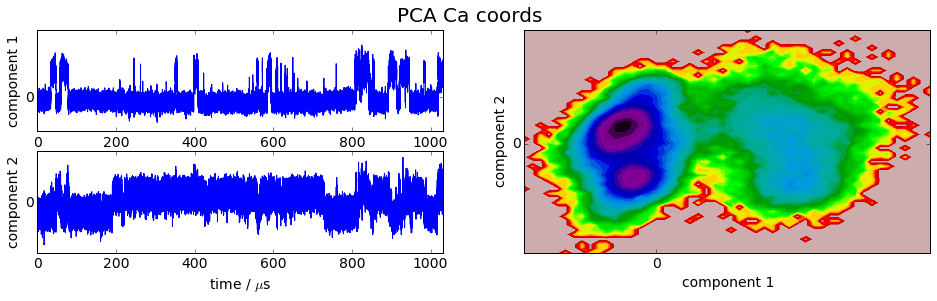

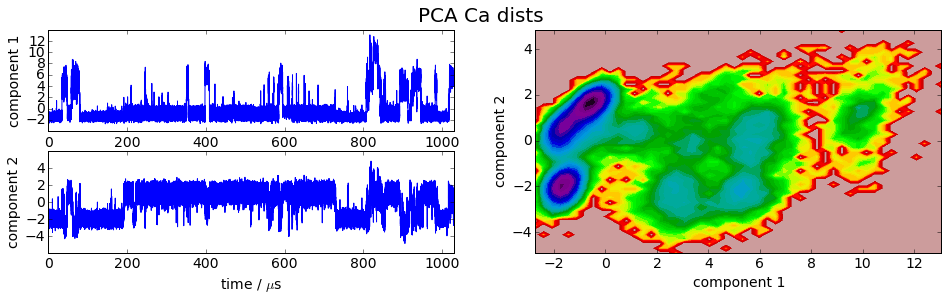

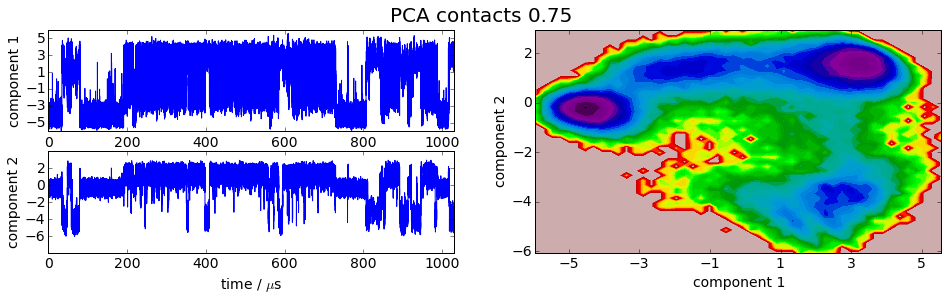

In [15]:
for i,Y in enumerate(pca_Ys):
    plot_map(Y, tickspacing1=2.0, tickspacing2=2.0, timestep=0.01, timeunit='$\mu$s')
    gcf().suptitle('PCA ' + labels[i], fontsize=20)
    savefig('./figs/pca_' + labels[i].replace(' ','_') + '.png', bbox_inches='tight')

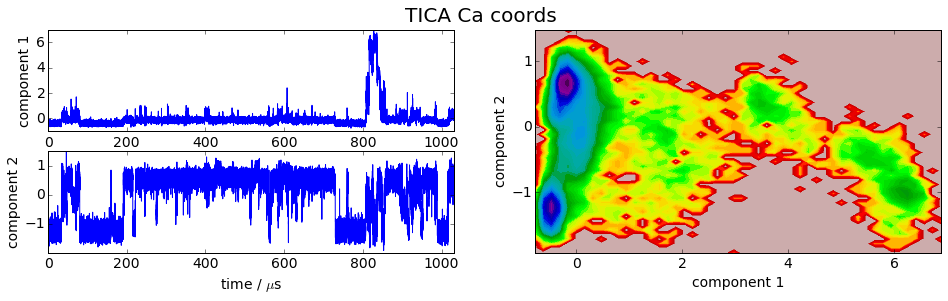

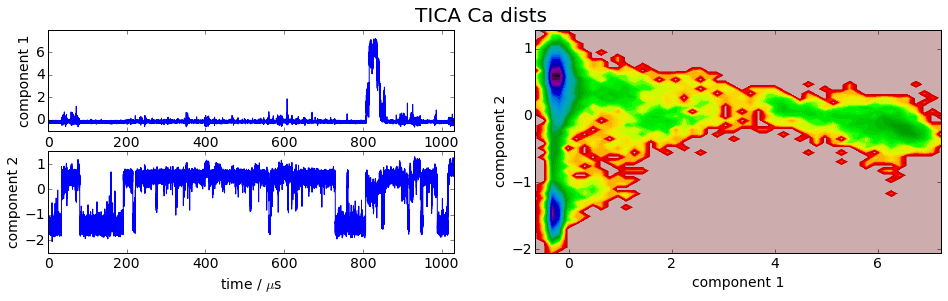

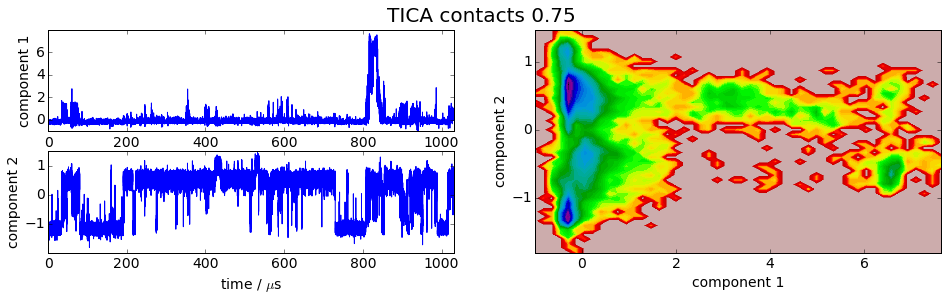

In [16]:
for i,Y in enumerate(tica_Ys):
    plot_map(Y, tickspacing1=2.0, tickspacing2=1.0, timestep=0.01, timeunit='$\mu$s')
    gcf().suptitle('TICA ' + labels[i], fontsize=20)
    savefig('./figs/tica_' + labels[i].replace(' ','_') + '.png', bbox_inches='tight')

It is apparent that the PCA projections strongly depend on the choice of input features, whereas the TICA results seem to lead to qualitatively similar pictures, i.e. TICA seems to have found about the same slow processes, whereas the large-variance processes are very different. This is encouraging for TICA.

Now we have a look on the total variance for PCA and the total kinetic variance [2] for TICA.

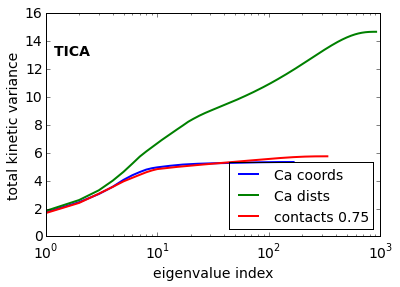

In [17]:
# total variance
for i, tica_obj in enumerate(ticas):
    plot(np.cumsum(tica_obj.eigenvalues**2), linewidth=2, label=labels[i])
text(1.2, 13, 'TICA ', fontweight='bold')
xlabel('eigenvalue index')
ylabel('total kinetic variance')
legend(fontsize=14, loc=4)
semilogx()
savefig('./figs/tica_totvar.png', bbox_inches='tight')

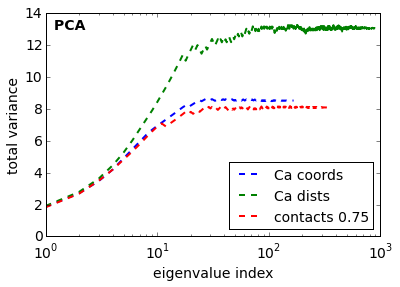

In [18]:
# total variance
for i, pca_obj in enumerate(ticas):
    plot(np.cumsum(pca_obj.eigenvalues), linewidth=2, label=labels[i], linestyle='dashed')
text(1.2, 13, 'PCA ', fontweight='bold')
xlabel('eigenvalue index')
ylabel('total variance')
legend(fontsize=14, loc=4)
semilogx()
savefig('./figs/pca_totvar.png', bbox_inches='tight')

What does this tell us about which input feature to select and which transformation method to us? 

TICA [6] is expected to perform better than PCA or any other method in terms of a transformation method to resolve the kinetics, because TICA has been demonstrated to be an optimal linear combination of input features in terms of resolving the solve processes (see Perez-Hernandez et al in [6]).

Within the TICA results the Ca-distances show the largest kinetic variance, which according to [2] indicates that this is the best feature selection. 

Let us put these indicators to the test...

MSM analysis
------

Now we estimate Markov state models and compute implied timescales [3]. According to the variational principle of conformation dynamics [4], models with longer timescales are preferable. Since we cluster with equally many states and in such a way that randomness is taken out of the clustering, this means that the corresponding selection of input feature and transformation method (PCA vs TICA) should be preferred if they lead to longer timescales. Furthermore, we prefer models that achieve converged relaxation timescales for shorter lag times.

The variational principle applies to systematic modelling errors, and we therefore need to compute statistical errors using Bayesian MSMs as described in [5] in order to see which differences are significant.

In [19]:
maxlag = 500
tica_itss = [msm.timescales_msm(cl_obj.dtrajs, lags=maxlag, nits=5, errors='bayes') for cl_obj in tica_cls]
pca_itss = [msm.timescales_msm(cl_obj.dtrajs, lags=maxlag, nits=5, errors='bayes') for cl_obj in pca_cls]

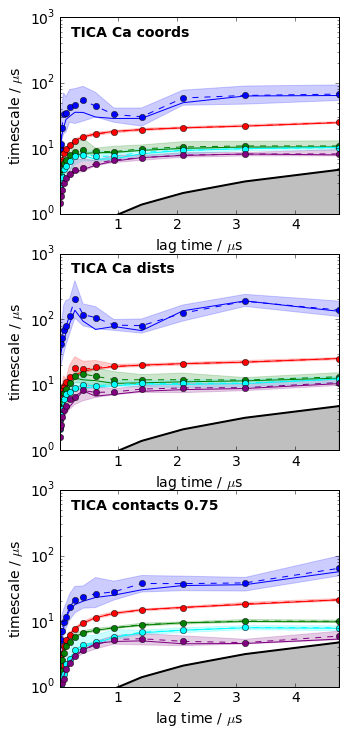

In [20]:
fig, axes = subplots(3, figsize=(5,12))
#axes = axes.flatten()
for i, its_obj in enumerate(tica_itss):
    mplt.plot_implied_timescales(its_obj, ax=axes[i], ylog=True, dt=0.01, units='$\mu$s')
    axes[i].text(0.2, 500, 'TICA ' + labels[i], fontweight='bold')
    axes[i].set_ylim(1, 1000)
savefig('./figs/tica_itss.png', bbox_inches='tight')

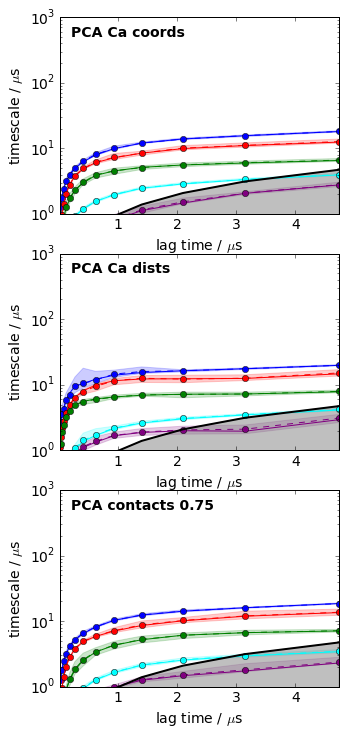

In [21]:
fig, axes = subplots(3, figsize=(5,12))
#axes = axes.flatten()
for i, its_obj in enumerate(pca_itss):
    mplt.plot_implied_timescales(its_obj, ax=axes[i], ylog=True, dt=0.01, units='$\mu$s')
    axes[i].text(0.2, 500, 'PCA ' + labels[i], fontweight='bold')
    axes[i].set_ylim(1, 1000)
savefig('./figs/pca_itss.png', bbox_inches='tight')

The above plots clearly confirm that TICA is much better than PCA at least for this system, and that Ca distances performed overall best for this system and within this set of features.

**Overall measure of quality**

Implied timescales are not really clear scores because different timecales may show different trends. We thus employ the total kinetic variance [2] of the MSM as a final score. The conclusions are the same as the above - independent of the lag time used.

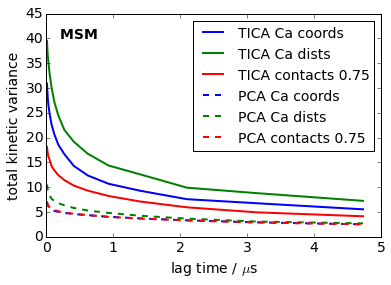

In [25]:
lags = tica_itss[0].lags
colors = ['blue', 'green', 'red']
kinvars = [[(M.eigenvalues()**2).sum() for M in its_obj.models] for its_obj in tica_itss]
for i, kinvar in enumerate(kinvars):
    plot(0.01*lags, kinvar, linewidth=2, label='TICA '+labels[i], color=colors[i])
kinvars = [[(M.eigenvalues()**2).sum() for M in its_obj.models] for its_obj in pca_itss]
for i, kinvar in enumerate(kinvars):
    plot(0.01*lags, kinvar, linewidth=2, label='PCA '+labels[i], color=colors[i], linestyle='dashed')
text(0.2, 40, 'MSM ', fontweight='bold')
xlabel('lag time / $\mu$s')
ylim(0, 45); ylabel('total kinetic variance')
legend(fontsize=14)
savefig('./figs/total_kinetic_variance.png', bbox_inches='tight')

References
---------

1. Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper
 JM, Salmon JK, Shan Y,\n",
    "Wriggers W: Atomic-level characterization of the structural dynamics of proteins.\n",
    "*Science* **330**:341-346 (2010). doi: 10.1126/science.1187409.\n",
    
2. Noé F, Clementi C: Kinetic distance and kinetic maps from molecular dynamics simulation. http://arxiv.org/abs/1506.06259

3. Swope, W. C., J. W. Pitera and F. Suits: Describing protein folding kinetics by molecular dynamics simulations: 1. Theory, J. Phys. Chem. B. 108, 6571-6581 (2004)

4. Noé, F. and F. Nüske: A variational approach to modeling slow processes in stochastic dynamical systems. SIAM Multiscale Model. Simul. 11. 635-655 (2013)

5. Trendelkamp-Schroer, B., W. Wu, F. Paul and F. Noé: Estimation and uncertainty of reversible Markov models. arxiv.org/pdf/1507.05990 (2015)

6. Pérez-Hernández G., F. Paul, T. Giorgino, G. De Fabritiis and F. Noé. J. Chem. Phys. 139, 015102 (2013); Schwantes, C. R. and V. S. Pande, J. Chem. Theory Comput. 9, 2000 (2013); Molgedey, L. and H. G. Schuster, Phys. Rev. Lett. 72, 3634 (1994)